MobileNetV4 라이브러리 설치 및 불러오기 => 일단 보류

In [1]:
#!pip install timm torch torchvision
#import timm
#import torch

# MobileNetV4 모델 불러오기 (pretrained=True로 사전학습 가중치 사용)
#model = timm.create_model('hf_hub:timm/mobilenetv4_hybrid_large.ix_e600_r384_in1k', pretrained=True)
#model.eval()

데이터 **준비**

In [2]:
from google.colab import drive
from pathlib import Path
import os
import json

import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

drive.mount('/content/drive')
dir_ = Path('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH')
filepaths = list(dir_.glob(r'**/*.jpg'))
print(filepaths)

label_dir = "/content/drive/My Drive/New_sample/라벨링데이터/CAT/ARMSTRETCH"
label_char = [str(filepaths[i]).split("/")[-2] \
          for i in range(len(filepaths))]


print(label_char)
labels = []
for i in label_char:
  label_file = i + ".json"
  json_path = os.path.join(label_dir, label_file)

  with open(json_path, 'r') as f:
    data = json.load(f)
    value = data['metadata']['animal']['breed']
    labels.append(value)

filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')



print(labels)




#dir2_ = Path('/content/drive/My Drive/New_sample/라벨링데이터/CAT/ARMSTRETCH')
#filepaths2 = list(dir2_.glob(r'**/*.json'))
#print(filepaths2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_60_timestamp_2400.jpg'), PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_55_timestamp_2200.jpg'), PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_50_timestamp_2000.jpg'), PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_335_timestamp_13400.jpg'), PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_75_timestamp_3000.jpg'), PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_215_timestamp_8600.jpg'), PosixPath('/content/drive/My Drive/New_sample/원천데이터/CAT/ARMSTRETCH/cat-armstretch-024858/frame_330_timestamp_13200.jpg'), PosixPath('/content/drive

모델 전처리

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

Number of pictures: 4755

Number of different labels: 15

Labels: ['노르웨이숲' '코리안 숏헤어' '먼치킨' '래그돌' '페르시안' '스코티쉬 스트레이드' '러시안블루' '시암' '벵갈'
 '브리티쉬 숏헤어' '스코티쉬 폴드' '스코티쉬 스트레이드 롱헤어' '아비시니안' '터키시 앙고라' '아메리칸 숏헤어']


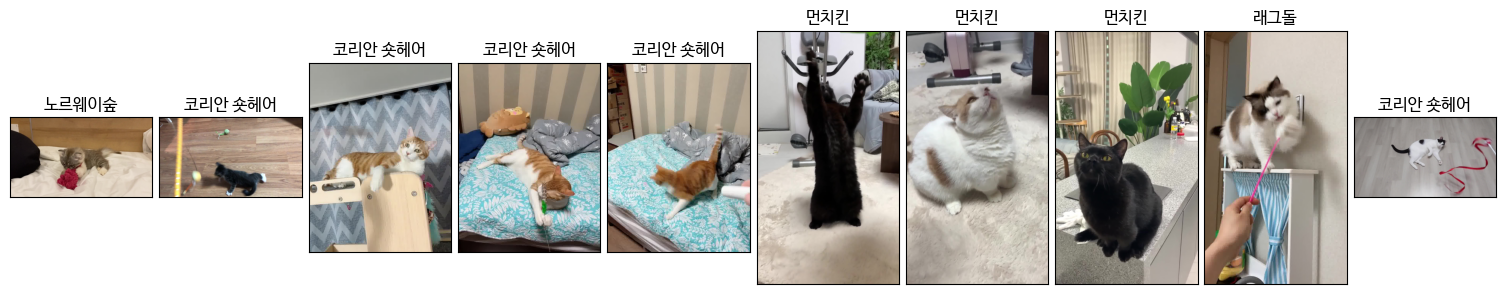

In [4]:
df = pd.concat([filepath, labels], axis=1)
df = df.sample(frac=1,random_state=0).reset_index(drop = True)
#데이터 셔플 후 1000개만 학습하기
#df = df.iloc[:2000]
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

plt.rc('font', family='NanumBarunGothic')
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

<ipython-input-5-44e930457559>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


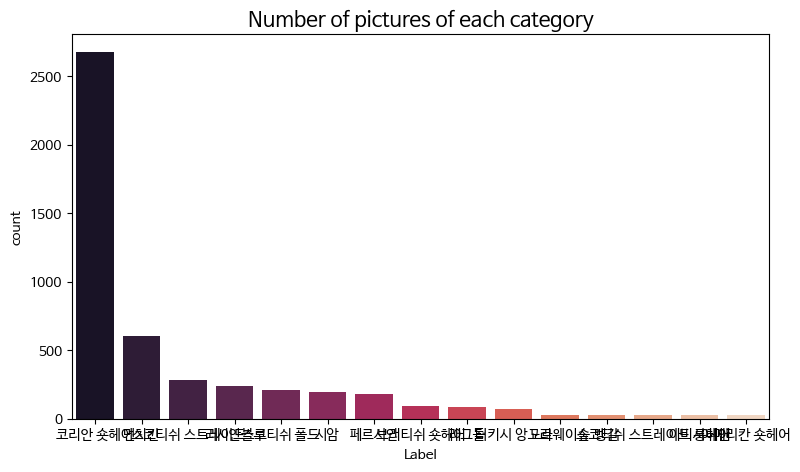

In [5]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [6]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((4279, 2), (476, 2))

데이터 전처리

In [7]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

전이 학습 모델

In [8]:
models = {
    #"DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    #"MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    #"EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    #"EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    #"InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    #"MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    #"MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    #"ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    #"ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    #"ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    #"VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    #"VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    #"Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(15, activation='softmax')(x)
    # 라벨 개수가 15개이기 때문에 Dense도 15로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 3852 validated image filenames belonging to 15 classes.
Found 427 validated image filenames belonging to 15 classes.
Found 476 validated image filenames belonging to 14 classes.




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 906s 7s/step - accuracy: 0.7169 - loss: 1.0270 - val_accuracy: 0.9930 - val_loss: 0.0588
MobileNetV3Small     trained in 918.25 sec


성능 확인

In [9]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

15/15 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step
**MobileNetV3Small has a 99.16% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV3Small,0.993,0.9916,918.25


모델 저장

In [10]:
 m.save('/content/drive/My Drive/model2.keras')  # 전체 모델 저장